In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import glambox as gb

%load_ext autoreload
%autoreload 2

In [2]:
## Load Krajbich & Rangel (2011) dataset estimates from Thomas, Molter et al. (2019)
estimates = pd.read_csv('resources/individual_estimates_sec_nhb2019.csv')
kr2011 = estimates.loc[estimates['dataset'] == 'krajbich2011']
kr2011.head()

,subject,dataset,v,gamma,s,tau
39,39,krajbich2011,1.207348,0.389116,0.227103,0.354587
40,40,krajbich2011,0.633304,0.353474,0.279450,0.622022
41,41,krajbich2011,0.737201,0.814595,0.282122,0.787967
42,42,krajbich2011,0.800456,-0.154669,0.328268,1.505673
43,43,krajbich2011,0.627823,0.658645,0.219142,0.549583


In [3]:
## Simulate a clinical dataset, with small groups and few trials
## Each individual's parameter set is sampled from the Krajbich & Rangel (2011) estimates, so that they are realistic
## Except for the gaze bias parameter gamma, which we explicitly vary between the groups.

np.random.seed(1751)

groups = ['group1', 'group2', 'group3']

# Sample sizes
N = dict(group1=5,
         group2=10,
         group3=15)

# Mean gaze bias parameters for each group
gamma_mu = dict(group1=0.7,     # weak bias
                group2=0.1,     # medium-strong bias
                group3=-0.5)    # very strong bias with leak

# Sample parameter sets from KR2011 estimates
group_idx = {group: np.random.choice(kr2011.index, size=N[group], replace=False)
             for group in groups}
v = {group: kr2011.loc[group_idx[group], 'v'].values
     for group in groups}
s = {group: kr2011.loc[group_idx[group], 's'].values
     for group in groups}
tau = {group: kr2011.loc[group_idx[group], 'tau'].values
       for group in groups}
# Draw normally distributed gaze bias parameters (truncated to be ≤ 1)
gamma = dict(group1=np.clip(np.random.normal(loc=gamma_mu['group1'], scale=0.3, size=N['group1']), a_min=None, a_max=1),
             group2=np.clip(np.random.normal(loc=gamma_mu['group2'], scale=0.2, size=N['group2']), a_min=None, a_max=1),
             group3=np.clip(np.random.normal(loc=gamma_mu['group3'], scale=0.3, size=N['group3']), a_min=None, a_max=1))

# Set the number of trials and items in the task
n_trials = 50
n_items  = 3

# Simulate the data using GLAM
glam = gb.GLAM()
for g, group in enumerate(groups):
    glam.simulate_group(kind='individual',
                        n_individuals=N[group],
                        n_trials=n_trials,
                        n_items=n_items,
                        parameters=dict(v=v[group],
                                        gamma=gamma[group],
                                        s=s[group],
                                        tau=tau[group],
                                        t0=np.zeros(N[group])),
                        label=group,
                        seed=g)

data = glam.data.copy()
data.rename({'condition': 'group'}, axis=1, inplace=True)
data.to_csv('examples/example_2/data/data.csv', index=False)
data.head(3)

,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,group
0,0.0,0.0,0.0,0.0,1.266691,5,0.459175,0,0.379466,3,0.161359,group1
1,0.0,1.0,0.0,2.0,1.189464,3,0.389115,7,0.189588,9,0.421297,group1
2,0.0,2.0,0.0,1.0,1.709817,3,0.269665,5,0.409055,2,0.321280,group1


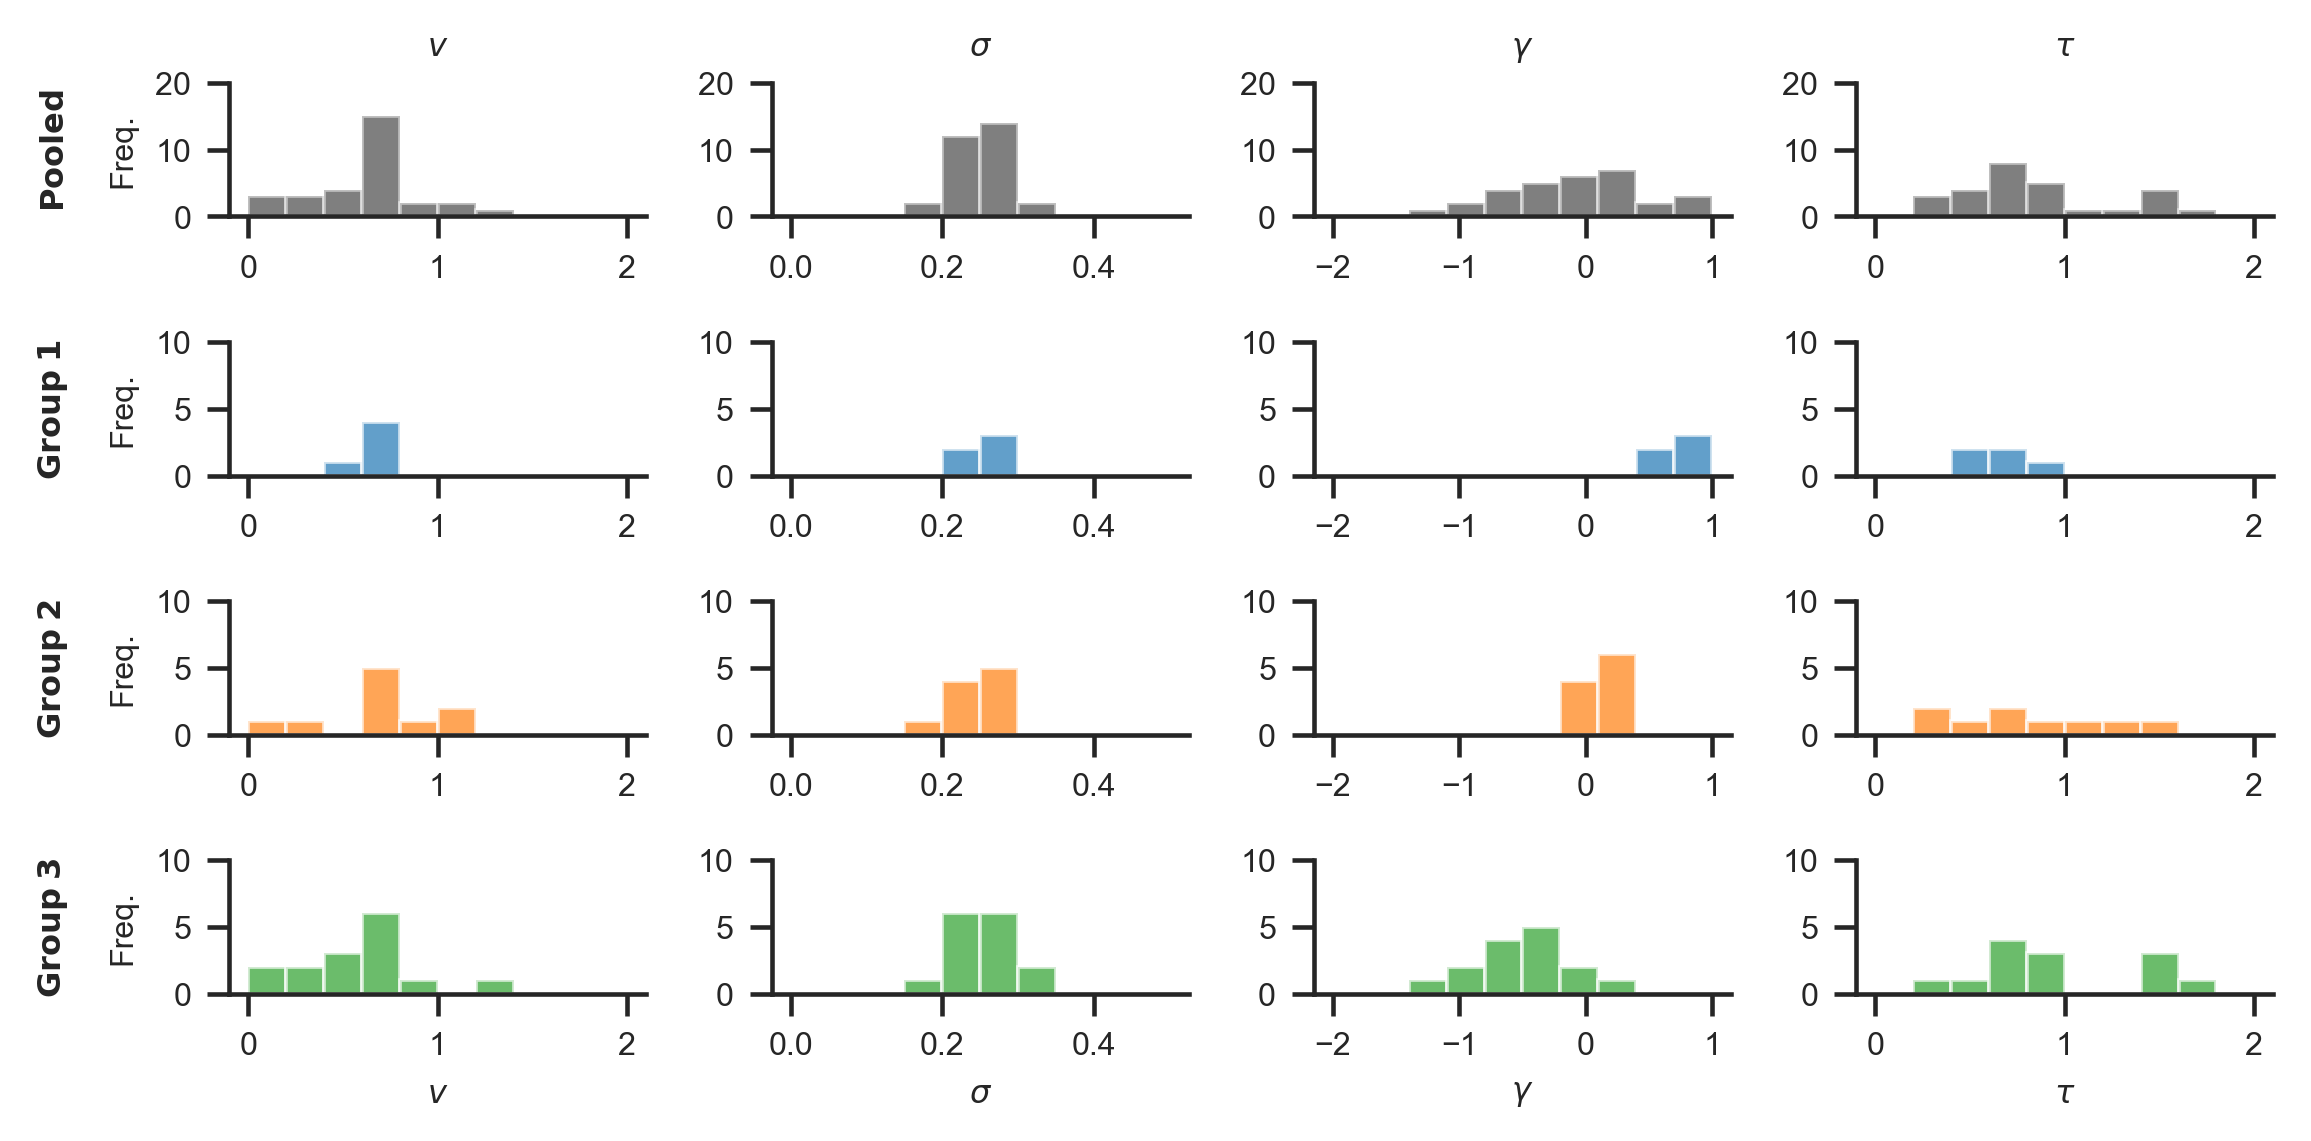

In [4]:
## Plot data generating parameters
from string import ascii_uppercase

fontsize = 7
n_bins = 10

fig, axs = plt.subplots(4, 4, figsize=gb.plots.cm2inch(18, 9), sharex='col', dpi=330)

for p, (parameter, parameter_name, bins) in enumerate(
    zip([v, s, gamma, tau],
        [r'$v$', r'$\sigma$', r'$\gamma$', r'$\tau$'],
        [np.linspace(0, 2, n_bins + 1),
         np.linspace(0, 0.5, n_bins + 1),
         np.linspace(-2, 1, n_bins + 1),
         np.linspace(0, 2, n_bins + 1)])):
    # Pooled
    axs[0, p].hist(np.concatenate([parameter[group] for group in groups]),
                   bins=bins,
                   color='black',
                   alpha=0.5)
    axs[0, p].set_ylim(0, 20)
    axs[0, p].set_yticks([0, 10, 20])
    axs[0, p].set_title(parameter_name, fontsize=fontsize, fontweight='bold')
    if p == 0:
        axs[0, p].set_ylabel(r'$\bf{Pooled}$' + '\n\nFreq.', fontsize=fontsize)

    # Groups
    for g, group in enumerate(groups):
        axs[g + 1, p].hist(parameter[group],
                           bins=bins,
                           color='C{}'.format(g),
                           alpha=0.7)
        axs[g + 1, p].set_ylim(0, 1)
        axs[g + 1, p].set_yticks([0, 5, 10])
        if p == 0:
            axs[g + 1, p].set_ylabel(r'$\bf{Group}$ ' + r'$\bf{{{g}}}$'.format(g=(g + 1)) + '\n\nFreq.',
                                     fontsize=fontsize)

    axs[g + 1, p].set_xlabel(parameter_name, fontsize=fontsize)
    
for ax, letter in zip(axs.ravel(), ascii_uppercase):
    # Show ticklabels, despite sharey=True
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

sns.despine()
    
fig.tight_layout(pad=1.02)

plt.savefig('examples/example_2/figures/generating_parameters.png', dpi=330)

In [5]:
## Check if the generating parameters, due to sampling, differ between groups, other than the gaze bias
from scipy.stats import ttest_ind

parameters = ['v', 'gamma', 's', 'tau']
comparisons=[('group1', 'group2'),
             ('group1', 'group3'),
             ('group2', 'group3')]

for p, parameter in zip([v, gamma, s, tau], ['v', 'gamma', 's', 'tau']):
    print(parameter)
    for comparison in comparisons:
        g1, g2 = comparison
        print('{} vs {}\t'.format(g1, g2), ttest_ind(p[g1], p[g2]))

v
group1 vs group2	 Ttest_indResult(statistic=-0.3063071158648262, pvalue=0.7642213460655614)
group1 vs group3	 Ttest_indResult(statistic=0.5357661157553092, pvalue=0.5986787412351837)
group2 vs group3	 Ttest_indResult(statistic=0.9437792037490204, pvalue=0.35509174773278895)
gamma
group1 vs group2	 Ttest_indResult(statistic=6.4021176850791575, pvalue=2.3355862858023058e-05)
group1 vs group3	 Ttest_indResult(statistic=6.8208382105890335, pvalue=2.193832426730825e-06)
group2 vs group3	 Ttest_indResult(statistic=4.837346716941595, pvalue=6.985175866537608e-05)
s
group1 vs group2	 Ttest_indResult(statistic=0.8636132045092535, pvalue=0.4034531813427481)
group1 vs group3	 Ttest_indResult(statistic=0.004104731012479496, pvalue=0.9967700581739689)
group2 vs group3	 Ttest_indResult(statistic=-0.8970137843731146, pvalue=0.37900526220793296)
tau
group1 vs group2	 Ttest_indResult(statistic=-0.8378245121922042, pvalue=0.417267319030197)
group1 vs group3	 Ttest_indResult(statistic=-1.61664947481003

In [6]:
data.groupby('group').apply(gb.analysis.aggregate_group_level_data, n_items=n_items)

/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


mean       std       min       max        se  \
group                                                                     
group1 Mean RT         1.960980  0.326799  1.531284  2.503894  0.163400   
       P(choose best)  0.876000  0.062482  0.760000  0.920000  0.031241   
       Gaze Influence  0.077391  0.066525 -0.005919  0.142432  0.033263   
group2 Mean RT         2.381671  1.402121  1.238400  5.187776  0.467374   
       P(choose best)  0.706000  0.065146  0.600000  0.800000  0.021715   
       Gaze Influence  0.255080  0.112799  0.103472  0.440610  0.037600   
group3 Mean RT         2.588283  1.256759  1.240456  6.318852  0.335883   
       P(choose best)  0.498667  0.155857  0.280000  0.820000  0.041655   
       Gaze Influence  0.382977  0.112599  0.144232  0.652829  0.030093   

                            iqr  
group                            
group1 Mean RT         0.304160  
       P(choose best)  0.060000  
       Gaze Influence  0.133686  
group2 Mean RT         0.336601  
       P(choose best)  0.100000  
       Gaze Influence  0.174701  
group3 Mean RT         0.872888  
       P(choose best)  0.200000  
       Gaze Influence  0.122224

/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


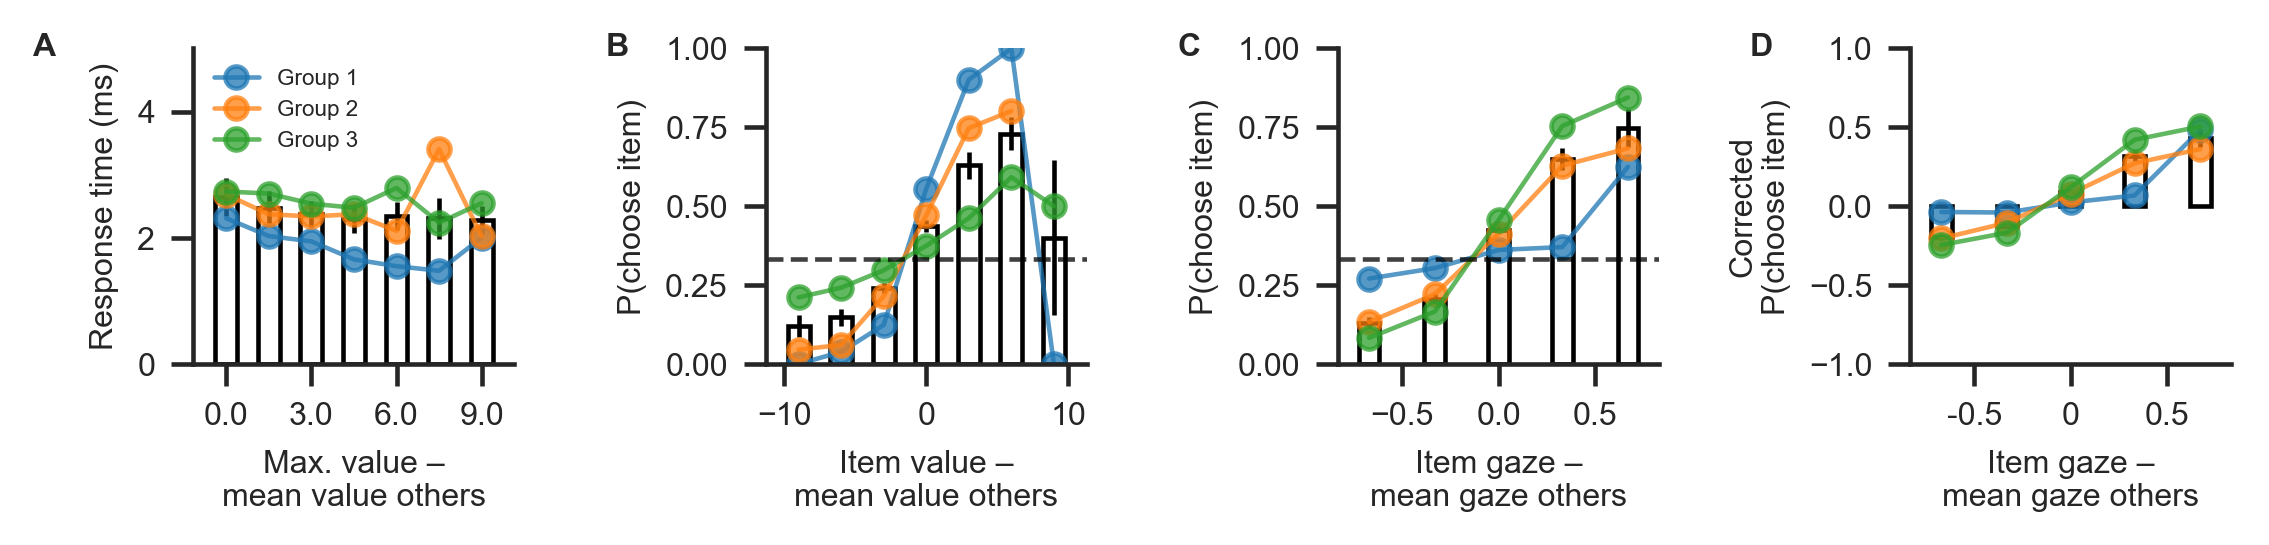

In [7]:
## Plot aggregate data across groups and for each group separately, to visualize behavioural differences between groups
gb.plots.plot_aggregate(bar_data=data,
                        line_data=[data.loc[data['group'] == group] for group in groups],
                        line_labels=['Group 1', 'Group 2', 'Group 3'],
                        value_bins=7, gaze_bins=7,
                        limits=dict(rt=(0, 5)));
sns.despine()
plt.savefig('examples/example_2/figures/aggregate_data.png', dp=330)

In [8]:
hglam = gb.GLAM(data=data)
hglam.make_model(kind='hierarchical',
                 depends_on=dict(v='group',
                                 gamma='group',
                                 s='group',
                                 tau='group'))

Generating hierarchical model for 30 subjects...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

In [9]:
np.random.seed(1958)
hglam.fit(method='MCMC',
          draws=10000, tune=90000,
          random_seed=1958)

Fitting 1 model(s) using MCMC...
  Fitting model 1 of 1...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

/!\ Automatically setting parameter precision...


In [10]:
hglam.estimates.to_csv('examples/example_2/results/estimates.csv', index=False)

In [11]:
variables = [v for v in hglam.trace[0].varnames
             if not v.endswith('__')
             and not v in ['b', 'p_error', 't0']]

pm.summary(hglam.trace[0], var_names=variables).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
v_group1_mu,0.660816,0.094859,0.001799,0.480959,0.853675,3004.318287,1.000555
v_group2_mu,0.698076,0.121030,0.001724,0.462678,0.950604,5941.721026,1.000064
v_group3_mu,0.613918,0.078723,0.001389,0.460091,0.764750,3977.350947,1.000187
v_group1_sd,0.170924,0.109011,0.002531,0.030539,0.375292,1746.639115,1.001141
v_group2_sd,0.365464,0.105161,0.001781,0.197836,0.578147,3372.156332,1.001472


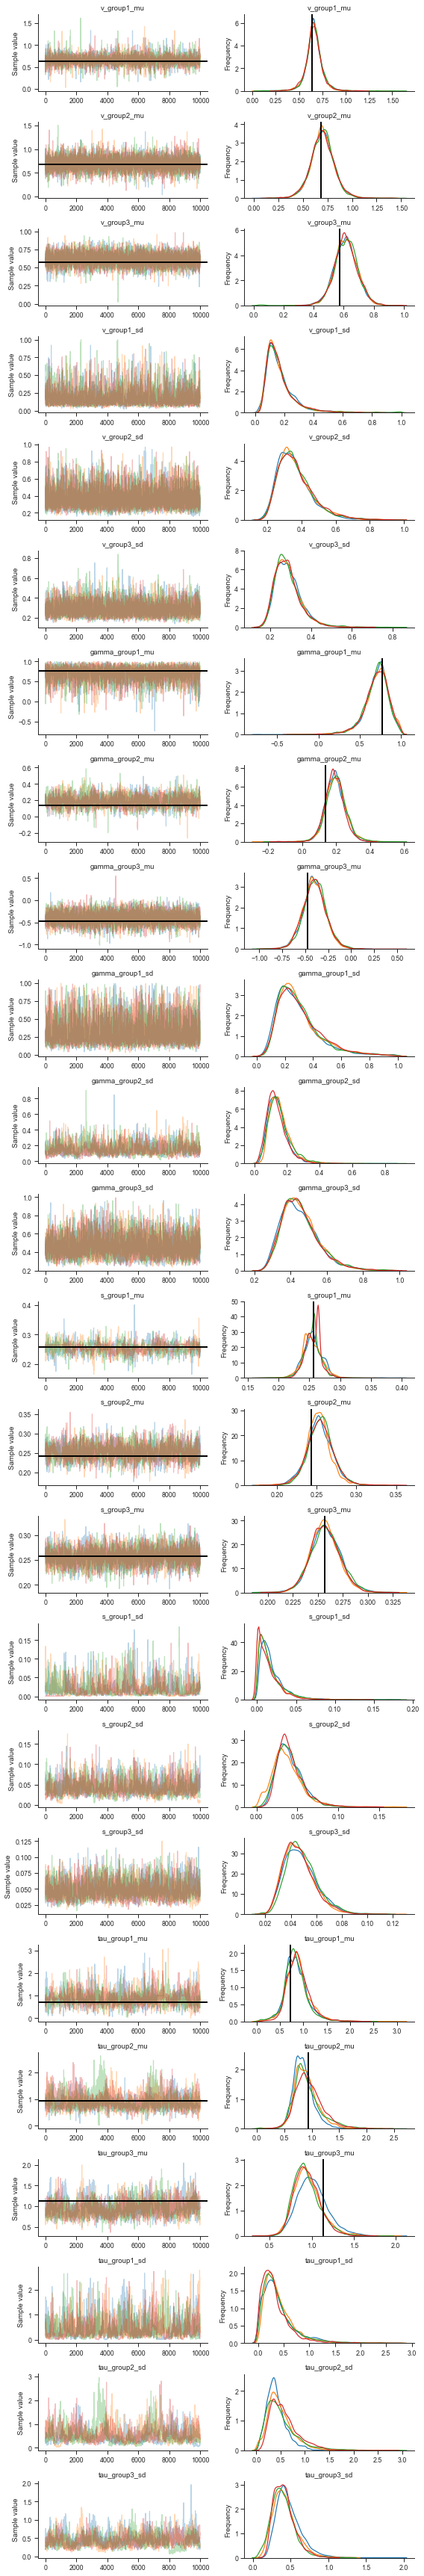

In [12]:
variables = [v for v in variables
             if v.endswith('_mu')
             or v.endswith('_sd')]
gb.plots.traceplot(hglam.trace[0],
          varnames=variables,
          ref_val=dict(v_group1_mu=v['group1'].mean(),
                       v_group2_mu=v['group2'].mean(),
                       v_group3_mu=v['group3'].mean(),
                       gamma_group3_mu=gamma['group3'].mean(),
                       gamma_group1_mu=gamma['group1'].mean(),
                       gamma_group2_mu=gamma['group2'].mean(),
                       s_group3_mu=s['group3'].mean(),
                       s_group1_mu=s['group1'].mean(),
                       s_group2_mu=s['group2'].mean(),
                       tau_group3_mu=tau['group3'].mean(),
                       tau_group1_mu=tau['group1'].mean(),
                       tau_group2_mu=tau['group2'].mean()))
plt.savefig('examples/example_2/figures/traceplot.png', dpi=330)
sns.despine()

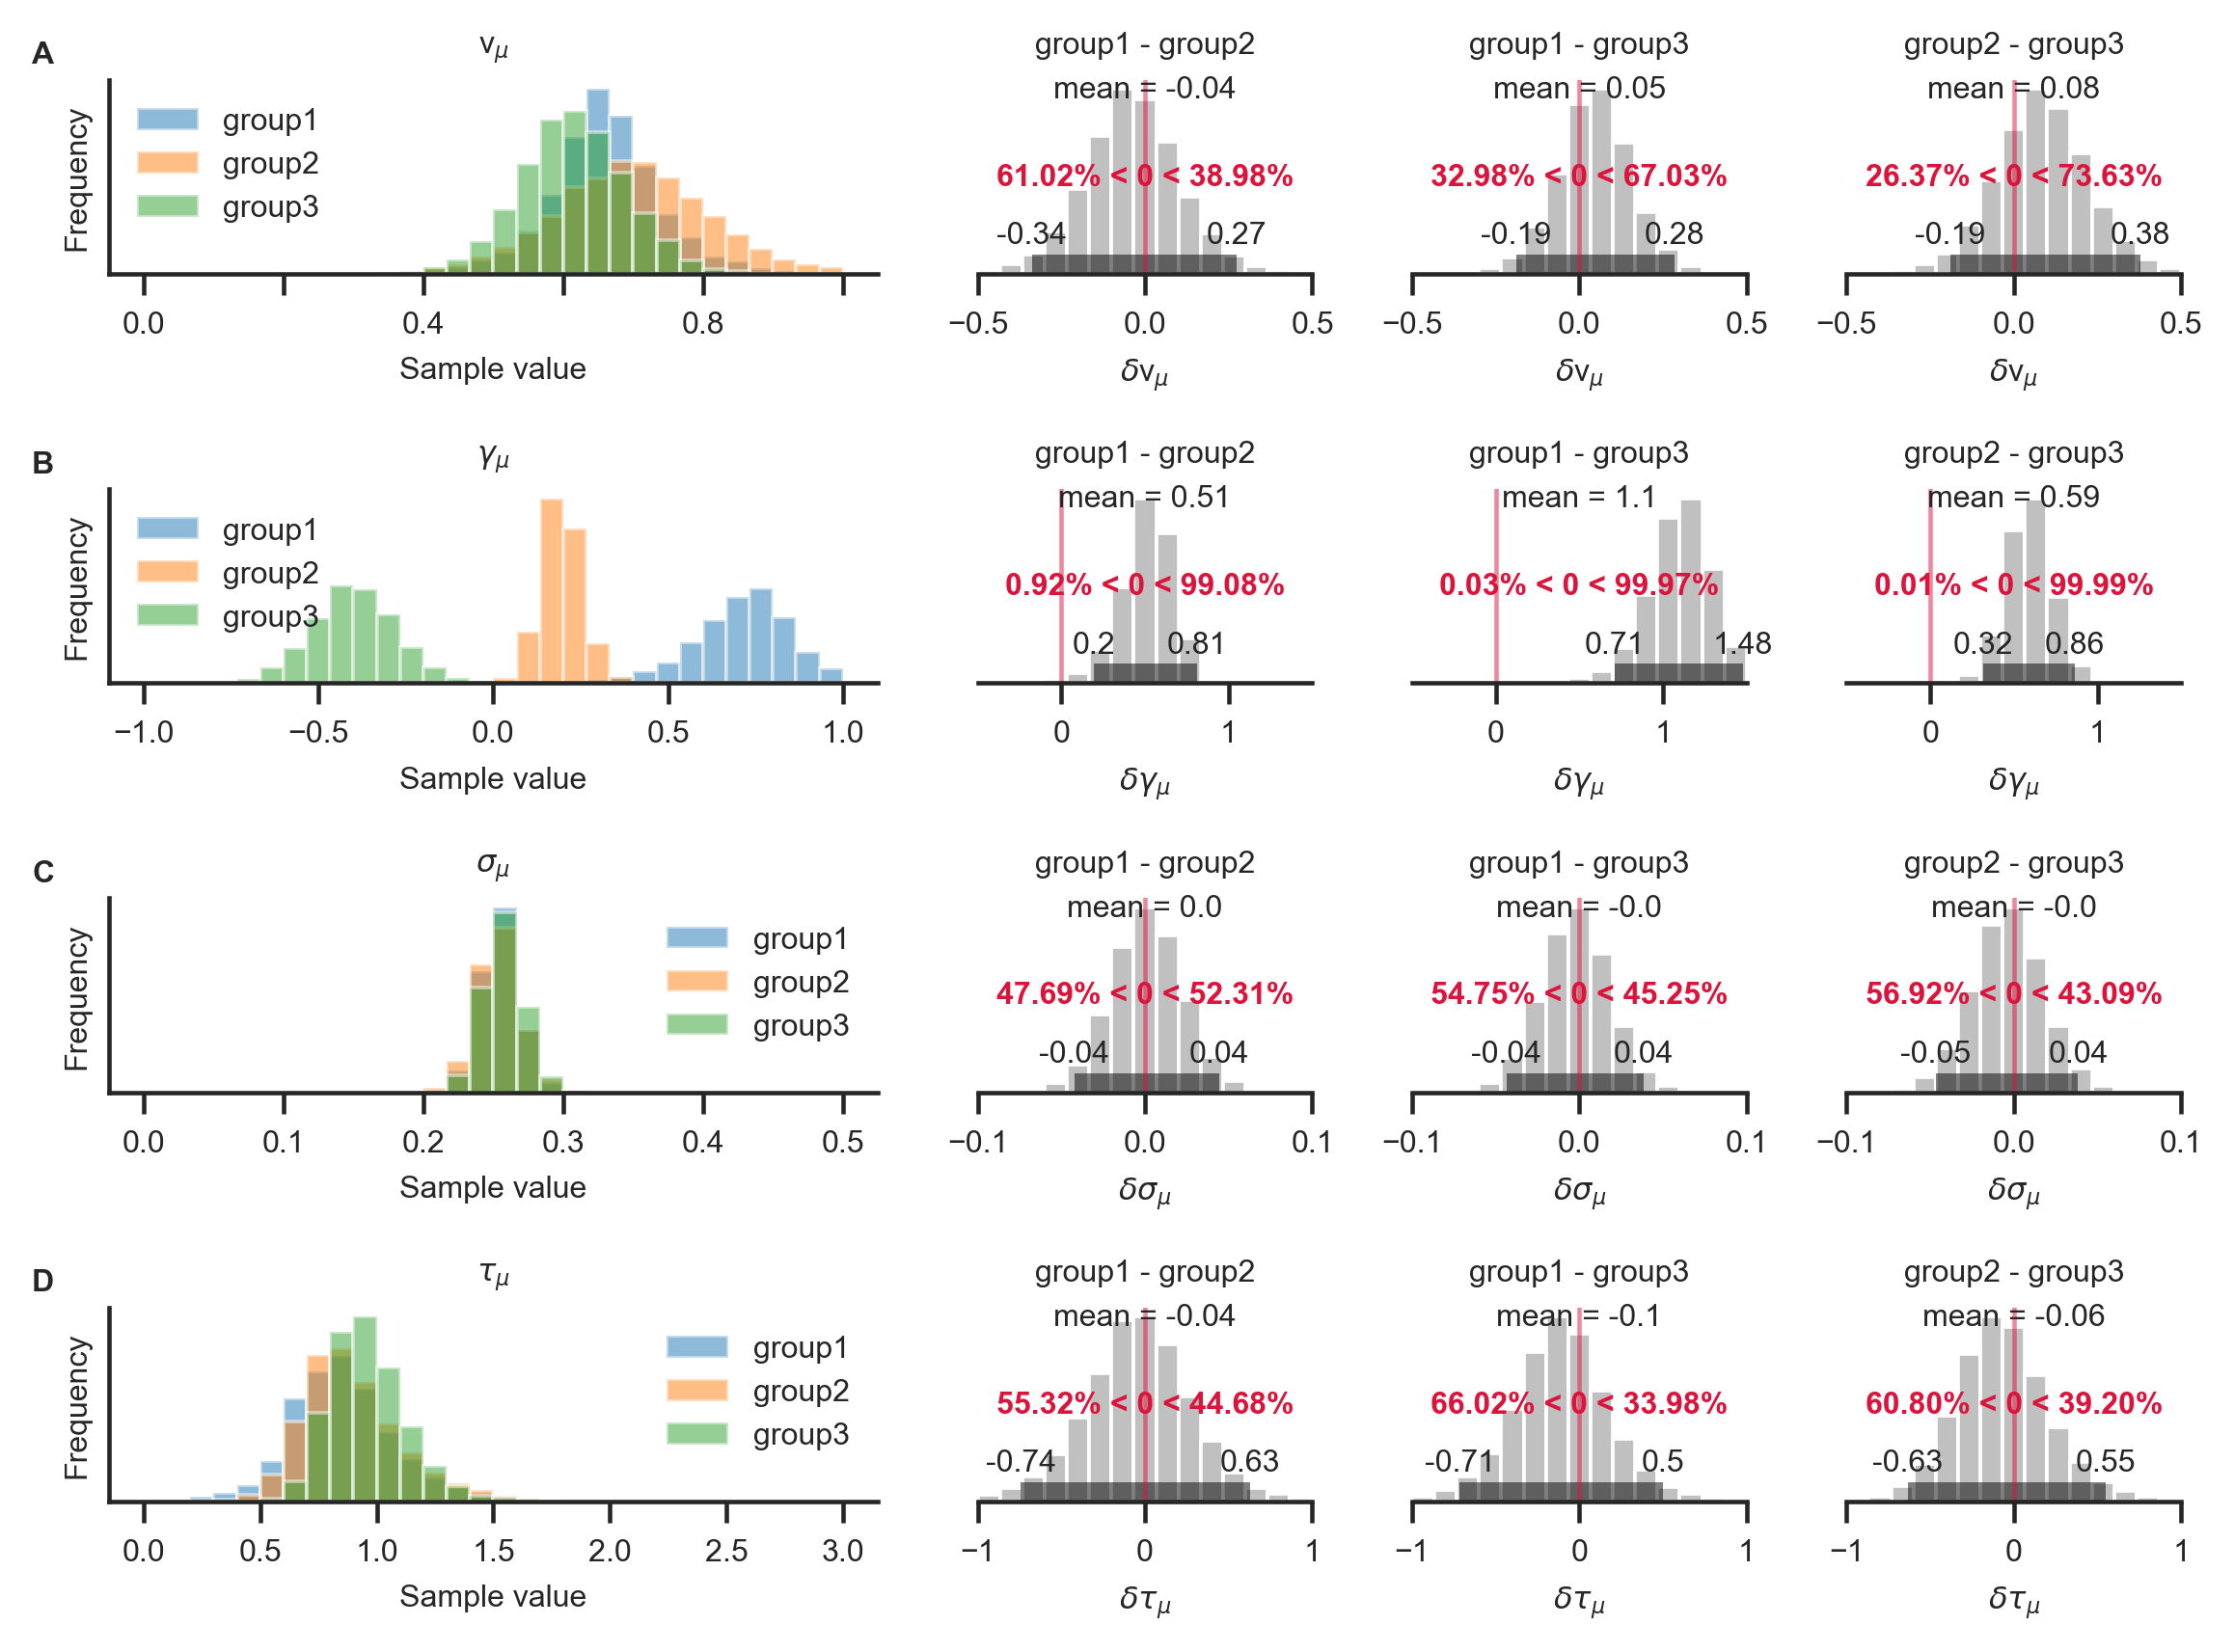

In [22]:
parameters = ['v', 'gamma', 's', 'tau']
comparisons=[('group1', 'group2'),
             ('group1', 'group3'),
             ('group2', 'group3')]

fig, axs = gb.plots.plot_node_hierarchical(hglam,
                                           parameters=parameters,
                                           comparisons=comparisons,
                                           xlimits=dict(v=dict(dist=(0, 1),
                                                               delta=(-0.5, 0.5)),
                                                        gamma=dict(dist=(-1, 1),
                                                                   delta=(-0.5, 1.5)),
                                                        s=dict(dist=(0, 0.5),
                                                               delta=(-0.1, 0.1)),
                                                        tau=dict(dist=(0, 3),
                                                                 delta=(-1, 1))));

plt.savefig('examples/example_2/figures/node_comparison.png', dpi=330)